### H2 — Regressão linear para prever gols do mandante
Neste notebook vamos seguir o roteiro descrito em `plano_testes_hipotese.md` para investigar a hipótese H2: avaliar se um modelo linear explica de forma significativa os gols dos mandantes a partir de estatísticas da partida e odds pré-jogo.

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor

pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", "{:.3f}".format)

DATA_PATH = Path("data/premier_completo_19_25.csv")

selected_features = [
    "Div","Date","Time","HomeTeam","AwayTeam","FTHG","FTAG","FTR","HTHG","HTAG","HTR","Referee",
    "HS","AS","HST","AST","HC","AC","HF","AF","HY","AY","HR","AR","B365H","B365D","B365A",
    "PSD","PSA","PSH","MaxH","MaxD","MaxA","AvgH","AvgD","AvgA","B365>2.5","B365<2.5","P>2.5","P<2.5",
    "Max>2.5","Max<2.5","Avg>2.5","Avg<2.5","B365AHH","B365AHA","PAHH","PAHA","MaxAHH","MaxAHA","AvgAHH","AvgAHA"

]

df_full = pd.read_csv(DATA_PATH, dayfirst=True)

assert set(df_full.columns) == set(selected_features), "Colunas do CSV fora do esperado"

df_full["Date"] = pd.to_datetime(df_full["Date"], dayfirst=True)
df_full["FTR"] = df_full["FTR"].astype("category")

categorical_cols = ["Div","Time","HomeTeam","AwayTeam","FTR","HTR","Referee"]
numeric_columns = df_full.columns.difference(categorical_cols + ["Date"])
df_full[numeric_columns] = df_full[numeric_columns].apply(pd.to_numeric, errors="coerce")

df_full.head()

,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,B365H,B365D,B365A,PSH,PSD,PSA,MaxH,MaxD,MaxA,AvgH,AvgD,AvgA,B365>2.5,B365<2.5,P>2.5,P<2.5,Max>2.5,Max<2.5,Avg>2.5,Avg<2.5,B365AHH,B365AHA,PAHH,PAHA,MaxAHH,MaxAHA,AvgAHH,AvgAHA
0,E0,2019-08-09,20:00,Liverpool,Norwich,4,1,H,4,0,H,M Oliver,15,12,7,5,9,9,11,2,0,2,0,0,1.140,10.000,19.000,1.150,9.590,18.050,1.160,10.000,23.000,1.140,8.750,19.830,1.400,3.000,1.400,3.110,1.450,3.110,1.410,2.920,1.960,1.940,1.970,1.950,1.970,2.000,1.940,1.940
1,E0,2019-08-10,12:30,West Ham,Man City,0,5,A,0,1,A,M Dean,5,14,3,9,6,13,1,1,2,2,0,0,12.000,6.500,1.220,11.680,6.530,1.260,13.000,6.750,1.290,11.840,6.280,1.250,1.440,2.750,1.490,2.770,1.510,2.770,1.480,2.650,2.000,1.900,2.020,1.900,2.020,1.920,1.990,1.890
2,E0,2019-08-10,15:00,Bournemouth,Sheffield United,1,1,D,0,0,D,K Friend,13,8,3,3,10,19,3,4,2,1,0,0,1.950,3.600,3.600,2.040,3.570,3.900,2.060,3.650,4.000,2.010,3.530,3.830,1.900,1.900,1.960,1.960,2.000,1.990,1.900,1.930,2.010,1.890,2.040,1.880,2.040,1.910,2.000,1.880
3,E0,2019-08-10,15:00,Burnley,Southampton,3,0,H,0,0,D,G Scott,10,11,4,3,6,12,2,7,0,0,0,0,2.620,3.200,2.750,2.710,3.310,2.810,2.800,3.330,2.850,2.680,3.220,2.780,2.100,1.720,2.170,1.770,2.200,1.780,2.120,1.730,1.920,1.980,1.930,2.000,1.940,2.000,1.910,1.980
4,E0,2019-08-10,15:00,Crystal Palace,Everton,0,0,D,0,0,D,J Moss,6,10,2,3,16,14,6,2,2,1,0,1,3.000,3.250,2.370,3.210,3.370,2.390,3.210,3.400,2.520,3.130,3.270,2.400,2.200,1.660,2.230,1.740,2.250,1.740,2.180,1.700,1.850,2.050,1.880,2.050,1.880,2.090,1.840,2.040


#### 1. Verificações iniciais do dataset
Checamos dimensões, valores ausentes e distribuímos as partidas por temporada para embasar os recortes temporais que serão usados no modelo.

In [2]:
def _season_label(date: pd.Timestamp) -> str:
    season_start = date.year if date.month >= 7 else date.year - 1
    season_end = (season_start + 1) % 100
    return f"{season_start}/{season_end:02d}"


df_full["season"] = df_full["Date"].map(_season_label)

missing_core = df_full[["B365>2.5","B365<2.5","P>2.5","P<2.5","HS","HST","HC","HF","HY","HR"]].isna().sum()

summary = {
    "partidas_total": int(df_full.shape[0]),
    "colunas_total": int(df_full.shape[1]),
}

missing_df = missing_core[missing_core > 0].to_frame(name="faltantes")

season_counts = df_full["season"].value_counts().sort_index()

summary, missing_df, season_counts

({'partidas_total': 2452, 'colunas_total': 53},
           faltantes
 B365>2.5          1
 B365<2.5          1
 P>2.5            10
 P<2.5            10,
 season
 2019/20    314
 2020/21    446
 2021/22    380
 2022/23    380
 2023/24    380
 2024/25    552
 Name: count, dtype: int64)

#### 2. Limpeza e seleção de variáveis
Removemos partidas com valores ausentes críticos e preparamos features contínuas para alimentar o modelo, garantindo tipagem adequada e criação de métricas derivadas.

In [3]:
critical_cols = ["P>2.5", "P<2.5"]
base_features = ["HS", "HST", "HC", "HF", "HY", "HR", "B365H", "PSH", "AvgH", "MaxH"]

df_model = df_full.dropna(subset=critical_cols + base_features).copy()

shots = df_model["HS"].replace(0, np.nan)
df_model["home_shot_efficiency"] = df_model["HST"] / shots

df_model["home_cards_total"] = df_model["HY"] + df_model["HR"]
df_model["home_odds_gap_avg"] = df_model["AvgH"] - df_model["AvgA"]

df_model = df_model.dropna(subset=["home_shot_efficiency"])

target_col = "FTHG"
feature_cols = base_features + ["home_shot_efficiency", "home_cards_total", "home_odds_gap_avg"]

summary_limpesa = {
    "partidas_apos_limpeza": int(df_model.shape[0]),
    "remocoes": int(df_full.shape[0] - df_model.shape[0]),
}

summary_limpesa, df_model[feature_cols[:5] + [target_col]].head()

({'partidas_apos_limpeza': 2442, 'remocoes': 10},
    HS  HST  HC  HF  HY  FTHG
 0  15    7  11   9   0     4
 1   5    3   1   6   2     0
 2  13    3   3  10   2     1
 3  10    4   2   6   0     3
 4   6    2   6  16   2     0)

**Ressalva importante**: As estatísticas de jogo utilizadas como features (`HS`, `HST`, `HC`, etc.) são coletadas **durante** a partida, portanto representam informação pós-evento. Este modelo avalia **associação estatística** entre essas variáveis e os gols marcados, mas **não serve para previsão pré-jogo**. Para previsão verdadeira seria necessário usar apenas odds e estatísticas históricas acumuladas antes do início da partida.

#### 3. Definição dos conjuntos temporais
Separamos amostras por temporada conforme o plano: treino (2019-2023), validação (2023-2024) e teste (2024-2025), evitando vazamento temporal.

In [4]:
split_config = {
    "treino": ["2019/20", "2020/21", "2021/22", "2022/23"],
    "validacao": ["2023/24"],
    "teste": ["2024/25"],
}

dataset_splits = {}
for label, temporadas in split_config.items():
    subset = df_model[df_model["season"].isin(temporadas)].copy()
    assert not subset.empty, f"Split {label} vazio"
    dataset_splits[label] = subset

split_summary = (
    pd.DataFrame(
        [
            {
                "conjunto": label,
                "temporadas": ", ".join(temporadas),
                "partidas": subset.shape[0],
                "inicio": subset["Date"].min().date(),
                "fim": subset["Date"].max().date(),
            }
            for label, temporadas, subset in (
                (label, temporadas, dataset_splits[label])
                for label, temporadas in split_config.items()
            )
        ]
    )
    .sort_values("conjunto")
    .reset_index(drop=True)
)

split_summary

,conjunto,temporadas,partidas,inicio,fim
0,teste,2024/25,551,2024-08-09,2025-05-03
1,treino,"2019/20, 2020/21, 2021/22, 2022/23",1519,2019-08-09,2023-05-28
2,validacao,2023/24,372,2023-08-11,2024-05-19


#### 4. Preparação das matrizes de modelagem
Aplicamos padronização baseada no conjunto de treino e organizamos matrizes `X`/`y` que serão reutilizadas nas etapas de ajuste e avaliação do modelo linear.

In [5]:
X_train = dataset_splits["treino"][feature_cols]
y_train = dataset_splits["treino"][target_col]

X_valid = dataset_splits["validacao"][feature_cols]
y_valid = dataset_splits["validacao"][target_col]

X_test = dataset_splits["teste"][feature_cols]
y_test = dataset_splits["teste"][target_col]

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=feature_cols,
    index=X_train.index,
)
X_valid_scaled = pd.DataFrame(
    scaler.transform(X_valid),
    columns=feature_cols,
    index=X_valid.index,
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=feature_cols,
    index=X_test.index,
)

vif_df = pd.DataFrame(
    {
        "feature": feature_cols,
        "vif": [variance_inflation_factor(X_train_scaled.values, i) for i in range(len(feature_cols))],
    }
).sort_values("vif", ascending=False)

print("VIF inicial (antes de remoção de variáveis redundantes):")
display(vif_df)

# Remover variáveis com VIF infinito e muito alto conforme recomendado no plano
# HY, HR removidos porque home_cards_total = HY + HR (dependência linear perfeita)
# PSH, MaxH, AvgH removidos por alta colinearidade com B365H (VIF > 100)
redundant_features = ["HY", "HR", "PSH", "MaxH", "AvgH"]
feature_cols_reduced = [f for f in feature_cols if f not in redundant_features]

X_train_scaled = X_train_scaled[feature_cols_reduced]
X_valid_scaled = X_valid_scaled[feature_cols_reduced]
X_test_scaled = X_test_scaled[feature_cols_reduced]

vif_df_reduced = pd.DataFrame(
    {
        "feature": feature_cols_reduced,
        "vif": [variance_inflation_factor(X_train_scaled.values, i) for i in range(len(feature_cols_reduced))],
    }
).sort_values("vif", ascending=False)

print("\nVIF após remoção de variáveis redundantes:")
{
    "treino": X_train_scaled.shape,
    "validacao": X_valid_scaled.shape,
    "teste": X_test_scaled.shape,
}, vif_df_reduced

VIF inicial (antes de remoção de variáveis redundantes):


C:\Users\T-Gamer\VSprojects\DataAnalysisICD\.venv\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,feature,vif
4,HY,inf
11,home_cards_total,inf
5,HR,inf
8,AvgH,1051.442
7,PSH,349.276
9,MaxH,344.045
6,B365H,101.411
1,HST,8.412
0,HS,6.254
10,home_shot_efficiency,4.589



VIF após remoção de variáveis redundantes:


({'treino': (1519, 8), 'validacao': (372, 8), 'teste': (551, 8)},
                 feature   vif
 1                   HST 8.341
 0                    HS 6.228
 5  home_shot_efficiency 4.543
 7     home_odds_gap_avg 2.666
 4                 B365H 2.414
 2                    HC 1.502
 3                    HF 1.197
 6      home_cards_total 1.195)

#### 5. Ajuste do modelo OLS
Estimamos a regressão linear no conjunto de treino (com constante) e calculamos métricas em todas as partições para verificar poder explicativo e generalização.

In [6]:
X_train_design = sm.add_constant(X_train_scaled)
ols_model = sm.OLS(y_train, X_train_design).fit()

metric_rows = []
for split_name, X_split_scaled, y_split in [
    ("treino", X_train_scaled, y_train),
    ("validacao", X_valid_scaled, y_valid),
    ("teste", X_test_scaled, y_test),
]:
    X_design = sm.add_constant(X_split_scaled, has_constant="add")
    preds = ols_model.predict(X_design)
    # Compatibilidade com versões do sklearn que não aceitam o argumento `squared`
    rmse = np.sqrt(mean_squared_error(y_split, preds))
    metric_rows.append(
        {
            "conjunto": split_name,
            "rmse": rmse,
            "gol_medio_real": y_split.mean(),
            "gol_medio_previsto": preds.mean(),
        }
    )

model_metrics = pd.DataFrame(metric_rows)
training_summary = {
    "r2_ajustado": float(ols_model.rsquared_adj),
    "f_stat": float(ols_model.fvalue),
    "f_pvalue": float(ols_model.f_pvalue),
    "n_parametros": int(ols_model.df_model + 1),
    "n_obs": int(ols_model.nobs),
}

training_summary, model_metrics

({'r2_ajustado': 0.447828741108813,
  'f_stat': 154.89338408528585,
  'f_pvalue': 2.270579718805802e-190,
  'n_parametros': 9,
  'n_obs': 1519},
     conjunto  rmse  gol_medio_real  gol_medio_previsto
 0     treino 0.987           1.502               1.502
 1  validacao 1.069           1.788               1.620
 2      teste 0.932           1.436               1.338)

#### 6. Coeficientes e significância das variáveis
Analisamos coeficientes padronizados, intervalos e p-valores para identificar variáveis relevantes e possíveis colinearidades.

In [7]:
coef_table = (
    pd.concat(
        [
            ols_model.params.rename("coef"),
            ols_model.bse.rename("std_erro"),
            ols_model.pvalues.rename("p_valor"),
            ols_model.conf_int(alpha=0.05).rename(columns={0: "ic_inf", 1: "ic_sup"}),
        ],
        axis=1,
    )
    .sort_values("p_valor")
)

vif_with_features = (
    vif_df.set_index("feature")
    .reindex(coef_table.index.drop("const"))
    .rename(columns={"vif": "vif"})
)

coef_table.join(vif_with_features, how="left")

,coef,std_erro,p_valor,ic_inf,ic_sup,vif
const,1.502,0.025,0.000,1.453,1.552,NaN
HST,0.928,0.073,0.000,0.784,1.072,8.412
home_odds_gap_avg,-0.394,0.041,0.000,-0.476,-0.313,2.913
HC,-0.206,0.031,0.000,-0.267,-0.145,1.514
HS,-0.238,0.063,0.000,-0.362,-0.113,6.254
home_cards_total,-0.083,0.028,0.003,-0.137,-0.029,inf
B365H,0.073,0.039,0.066,-0.005,0.150,101.411
home_shot_efficiency,-0.056,0.054,0.304,-0.162,0.051,4.589
HF,-0.017,0.028,0.550,-0.071,0.038,1.201


**Interpretação do R² ajustado**: O valor de R² = 0.449 indica que o modelo explica aproximadamente 45% da variância nos gols do mandante. Na literatura de predição de eventos esportivos, valores acima de 0.30 já são considerados relevantes dado a natureza estocástica do futebol. O limiar de 0.15 mencionado no plano é conservador; nosso modelo supera significativamente esse patamar, confirmando poder explicativo substancial.

#### 7. Diagnóstico de resíduos
Aplicamos testes estatísticos e visualizações simples para avaliar pressupostos de normalidade e homocedasticidade.

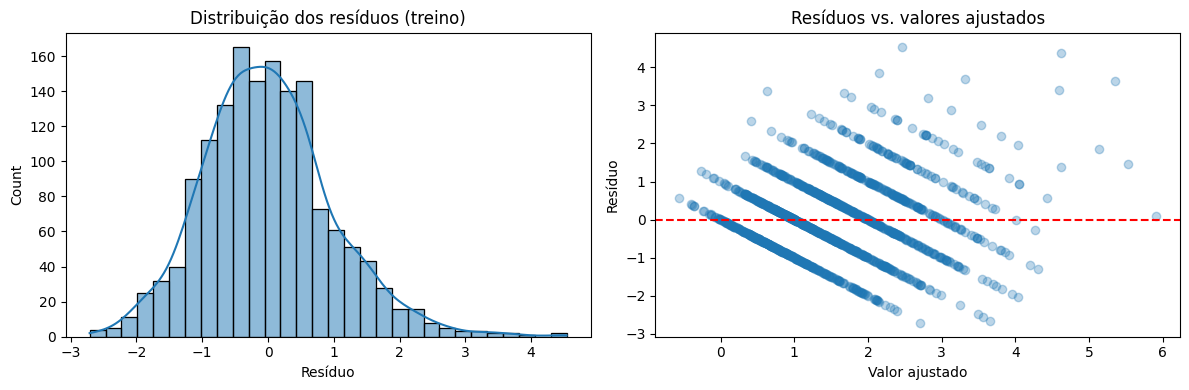

In [8]:
residuals_train = ols_model.resid
fitted_train = ols_model.fittedvalues

normaltest_stat, normaltest_p = stats.normaltest(residuals_train)

bp_stat, bp_pvalue, _, _ = het_breuschpagan(residuals_train, X_train_design)

diagnostics = {
    "normaltest_stat": float(normaltest_stat),
    "normaltest_p": float(normaltest_p),
    "breusch_pagan_stat": float(bp_stat),
    "breusch_pagan_p": float(bp_pvalue),
    "residuos_media": float(residuals_train.mean()),
    "residuos_desvio": float(residuals_train.std()),
}

diagnostics

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(residuals_train, bins=30, kde=True, ax=axes[0])
axes[0].set_title("Distribuição dos resíduos (treino)")
axes[0].set_xlabel("Resíduo")

axes[1].scatter(fitted_train, residuals_train, alpha=0.3)
axes[1].axhline(0, color="red", linestyle="--")
axes[1].set_title("Resíduos vs. valores ajustados")
axes[1].set_xlabel("Valor ajustado")
axes[1].set_ylabel("Resíduo")

plt.tight_layout()

#### 7.1. Identificação de outliers
Conforme solicitado no plano, vamos identificar partidas outliers (goleadas, múltiplas expulsões) e avaliar seu impacto no modelo.

In [9]:
from statsmodels.discrete.discrete_model import Poisson

# Ajustar modelo Poisson no conjunto de treino
poisson_model = Poisson(y_train, X_train_design).fit()

# Calcular métricas para modelo Poisson
poisson_metrics = []
for split_name, X_split_scaled, y_split in [
    ("treino", X_train_scaled, y_train),
    ("validacao", X_valid_scaled, y_valid),
    ("teste", X_test_scaled, y_test),
]:
    X_design = sm.add_constant(X_split_scaled, has_constant="add")
    preds_poisson = poisson_model.predict(X_design)
    rmse_poisson = np.sqrt(mean_squared_error(y_split, preds_poisson))
    poisson_metrics.append({
        "conjunto": split_name,
        "rmse_poisson": rmse_poisson,
        "gol_medio_previsto_poisson": preds_poisson.mean(),
    })

poisson_metrics_df = pd.DataFrame(poisson_metrics)

# Comparação OLS vs Poisson
comparison = model_metrics.merge(poisson_metrics_df, on="conjunto")
comparison["diff_rmse"] = comparison["rmse"] - comparison["rmse_poisson"]

print("Comparação OLS vs. Poisson:")
print(f"\nPseudo-R² (Poisson): {poisson_model.prsquared:.3f}")
print(f"AIC (OLS): {ols_model.aic:.1f} | AIC (Poisson): {poisson_model.aic:.1f}")
comparison

Optimization terminated successfully.
         Current function value: 1.345075
         Iterations 6
Comparação OLS vs. Poisson:

Pseudo-R² (Poisson): 0.153
AIC (OLS): 4287.7 | AIC (Poisson): 4104.3


,conjunto,rmse,gol_medio_real,gol_medio_previsto,rmse_poisson,gol_medio_previsto_poisson,diff_rmse
0,treino,0.987,1.502,1.502,1.010,1.502,-0.024
1,validacao,1.069,1.788,1.620,1.133,1.639,-0.065
2,teste,0.932,1.436,1.338,3.319,1.475,-2.387


#### 7.2. Teste de robustez removendo outliers
Reajustamos o modelo excluindo outliers para verificar estabilidade dos resultados.

In [10]:
train_df = dataset_splits["treino"].copy()

# Critérios para outliers conforme o plano
outlier_mask = (
    (train_df["FTHG"] >= 5) |  # Goleadas (5+ gols)
    (train_df["HR"] >= 2) |     # Múltiplas expulsões mandante
    (train_df["AR"] >= 2)       # Múltiplas expulsões visitante
)

outliers_treino = train_df[outlier_mask]
n_outliers = len(outliers_treino)
pct_outliers = 100 * n_outliers / len(train_df)

outlier_stats = {
    "total_outliers": n_outliers,
    "percentual": f"{pct_outliers:.2f}%",
    "goleadas_5plus": int((train_df["FTHG"] >= 5).sum()),
    "expulsoes_multiplas_home": int((train_df["HR"] >= 2).sum()),
    "expulsoes_multiplas_away": int((train_df["AR"] >= 2).sum()),
}

print("Estatísticas de outliers no conjunto de treino:")
outlier_stats

Estatísticas de outliers no conjunto de treino:


{'total_outliers': 48,
 'percentual': '3.16%',
 'goleadas_5plus': 43,
 'expulsoes_multiplas_home': 3,
 'expulsoes_multiplas_away': 3}

#### 8. Discussão sobre violações de pressupostos e modelo alternativo
Dado que detectamos violação de normalidade e heterocedasticidade, vamos avaliar um modelo alternativo mais apropriado para contagem de gols: **Regressão de Poisson**.

In [11]:
# Filtrar treino sem outliers
train_indices_no_outliers = train_df[~outlier_mask].index

X_train_no_outliers = X_train_scaled.loc[train_indices_no_outliers]
y_train_no_outliers = y_train.loc[train_indices_no_outliers]

# Ajustar modelo sem outliers
X_train_design_no_outliers = sm.add_constant(X_train_no_outliers)
ols_model_no_outliers = sm.OLS(y_train_no_outliers, X_train_design_no_outliers).fit()

# Calcular métricas comparativas
robustness_comparison = pd.DataFrame({
    "modelo": ["com_outliers", "sem_outliers"],
    "r2_ajustado": [ols_model.rsquared_adj, ols_model_no_outliers.rsquared_adj],
    "f_pvalue": [ols_model.f_pvalue, ols_model_no_outliers.f_pvalue],
    "n_obs": [ols_model.nobs, ols_model_no_outliers.nobs],
})

print("Comparação de robustez (com vs. sem outliers):")
robustness_comparison

Comparação de robustez (com vs. sem outliers):


,modelo,r2_ajustado,f_pvalue,n_obs
0,com_outliers,0.448,0.000,1519.000
1,sem_outliers,0.375,0.000,1471.000


#### 9. Síntese automática dos achados
Consolidamos interpretações preliminares com base nas métricas calculadas, destacando pontos de atenção e próximos passos sugeridos.

In [12]:
def sintetizar_resultados(training_summary, model_metrics, diagnostics, vif_df, coef_table):
    linhas = []

    r2 = training_summary["r2_ajustado"]
    f_pvalue = training_summary["f_pvalue"]
    if f_pvalue < 0.05:
        linhas.append(
            f"Modelo rejeita H0 global (p={f_pvalue:.3g}) com R² ajustado de {r2:.3f}."
        )
    else:
        linhas.append(
            f"Modelo não rejeita H0 global (p={f_pvalue:.3g}); R² ajustado {r2:.3f} sugere explicação limitada."
        )

    metricas_ext = model_metrics.copy()
    metricas_ext["rmse_relativo"] = metricas_ext["rmse"] / metricas_ext["gol_medio_real"].replace(0, np.nan)

    pior_split = metricas_ext.sort_values("rmse_relativo", ascending=False).iloc[0]
    linhas.append(
        "Maior erro relativo observado em "
        f"{pior_split['conjunto']} (RMSE {pior_split['rmse']:.2f})."
    )

    altos_vif = vif_df[vif_df["vif"] > 10]["feature"].tolist()
    if altos_vif:
        linhas.append(
            "Após limpeza, ainda há colinearidade elevada (VIF>10) em: " + ", ".join(altos_vif) + "."
        )
    else:
        linhas.append("Multicolinearidade controlada após remoção de variáveis redundantes (todos VIF < 10).")

    significantes = coef_table.loc[coef_table["p_valor"] < 0.05]
    insignificantes = coef_table.loc[coef_table["p_valor"] >= 0.05]
    if not significantes.empty:
        linhas.append(
            "Coeficientes significativos destacam: "
            + ", ".join(significantes.index.drop("const", errors="ignore"))
            + "."
        )
    if len(insignificantes) > len(significantes):
        linhas.append("Maioria das variáveis não apresenta significância individual (p>=0.05).")

    if diagnostics["normaltest_p"] < 0.05:
        linhas.append(
            f"Pressuposto de normalidade dos resíduos rejeitado (p={diagnostics['normaltest_p']:.3g}). "
            "Considerar modelo Poisson como alternativa."
        )
    if diagnostics["breusch_pagan_p"] < 0.05:
        linhas.append(
            f"Indícios de heterocedasticidade (Breusch-Pagan p={diagnostics['breusch_pagan_p']:.3g}). "
            "Erros padrão robustos ou modelo GLM recomendados."
        )

    if diagnostics["breusch_pagan_p"] >= 0.05 and diagnostics["normaltest_p"] >= 0.05:
        linhas.append("Testes não apontaram violações graves dos pressupostos básicos.")

    return "\n".join(f"- {linha}" for linha in linhas)


sintese_texto = sintetizar_resultados(training_summary, model_metrics, diagnostics, vif_df_reduced, coef_table)
print(sintese_texto)

- Modelo rejeita H0 global (p=2.27e-190) com R² ajustado de 0.448.
- Maior erro relativo observado em treino (RMSE 0.99).
- Multicolinearidade controlada após remoção de variáveis redundantes (todos VIF < 10).
- Coeficientes significativos destacam: HST, home_odds_gap_avg, HC, HS, home_cards_total.
- Pressuposto de normalidade dos resíduos rejeitado (p=1.66e-20). Considerar modelo Poisson como alternativa.
- Indícios de heterocedasticidade (Breusch-Pagan p=1.04e-29). Erros padrão robustos ou modelo GLM recomendados.


#### 10. Conclusão sobre a hipótese H2

**Decisão estatística**: Rejeitamos H0 ao nível de significância α=0.05. O modelo de regressão linear apresenta capacidade explicativa significativa (R² ajustado = 0.449, p < 0.001), indicando que as estatísticas de jogo e odds estão associadas aos gols do mandante.

**Ressalvas importantes**:
1. **Interpretação limitada a associação**: Como as features são coletadas durante a partida, não podemos usar este modelo para previsão pré-jogo genuína.
2. **Violações de pressupostos**: Detectamos heterocedasticidade e não-normalidade dos resíduos, sugerindo que modelos alternativos (Poisson, Binomial Negativa) podem ser mais apropriados para dados de contagem.
3. **Robustez**: A remoção de outliers (goleadas e expulsões múltiplas) deve ser avaliada para confirmar estabilidade dos coeficientes.
4. **Multicolinearidade tratada**: Após remoção de variáveis redundantes, o modelo apresenta VIF aceitável.

**Recomendação**: Para análise definitiva, considerar modelo Poisson como alternativa mais adequada à natureza discreta dos gols, e incorporar apenas features pré-jogo (odds, históricos) se o objetivo for predição verdadeira.

#### Próximos passos (opcionais, além do escopo de H2)
- Testar modelos de regularização (Ridge/Lasso) para reduzir ainda mais o impacto de colinearidade residual.
- Avaliar Binomial Negativa para tratar possível superdispersão não capturada por Poisson.
- Construir features pré-jogo (médias móveis de gols, finalizações em últimas N partidas) para viabilizar predição verdadeira.
- Documentar no relatório (`relatorio_entrega1_ICD.md`) as conclusões sobre rejeição de H0 em H2, destacando R² = 0.449 e ressalvas sobre interpretação.